# Meta Learners

Aim:
* Gain familiarity with meta-learners (S-learner, T-learner, X-learner, double-debiased) and their strenghts/ limitations
* Gain familiarity with interpreting gain charts

Methodology
1) Create a simulated dataset with causal relationship and confounders (to better control for "real" relationships)
2) Train meta learners and score out using gain chart


## 1. Set up

### 1.1 Import packages

In [1]:
# import required packages

import numpy as np
import pandas as pd 
import array
from matplotlib import pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

### 1.2 Create simulated dataset

Requirements
* Non-linear treatment effect
* Heterogenous treatment effect given other covariates
* Confounders
* Ignore colliders for now (explore methods to identify and exclude in future)
* <s>Test dataset is a randomised controlled experiment, so no confounders (the better to evaluate the model)</s>


<b>How does credit limit affect balance?</b>

<u>Simulated causal relationships</u>

credit_hunger (unobserved) -> credit_score -> credit_limit

credit_hunger + credit_hunger -> balance
- if credit_hunger is high, balance will be close to credit_limit
- if credit_hunger is low, balance will scale less strongly with credit_limit
- balance cannot exceed credit_limit

<i> Relationship of interest </i>

E(balance) = f(credit_limit | credit_score)

<i> Back-door path </i>

credit_limit <--- credit_score <--- credit_hunger ---> balance

In [2]:
class SimulatedCreditLimitDataset:

    def __init__(self):

        self.df_exists = False

    def create_simulated_dataset(
            self
            , sample_size: int = 10000
            , credit_hunger_effect_credit_score: int = -20 # higher credit hunger = worse credit score
            , credit_score_other_variance:int = 100
            , credit_score_mean: int = 500
            , credit_limits: list = [1000,2500,5000,10000,20000,40000]
            , limit_score_thresholds: list = [0,350,500,550,600,650,999]
            , limit_test_perc:float = 0.2
            , balance_noise_size: float = 0.1
            , **kwargs
            ):
        

        assert self.df_exists == False, "Simulated dataset already created or loaded"

        assert 0 <= limit_test_perc <= 1, "limit_test_perc must be between 0 and 1"
        assert 0 <= balance_noise_size <= 1, "balance_noise_size must be between 0 and 1"

        self.credit_limits = credit_limits
        self.limit_score_thresholds = limit_score_thresholds
        
        # credit hunger - values 1 (not hungry), 2 (medium), 3 (very hungry)
        _assign_credit_hunger = lambda x: 1 if x < 0.2 else (2 if x < 0.8 else 3)

        _credit_hunger = map(_assign_credit_hunger,  np.random.uniform(size= sample_size))
        _credit_hunger = np.array(list(_credit_hunger))

        # credit score - value from 400 to 700, average 500.

        _credit_score = (
            credit_score_mean 
            + (credit_hunger_effect_credit_score * (_credit_hunger - 2))
            + (credit_score_other_variance * np.random.standard_normal(sample_size))
        )

        _credit_score = np.clip(np.round(_credit_score).astype(int),300,700)

        # credit limit - (almost) deterministic based on credit_score
        # to give some variability for modelling (and simulate limit testing), x % will get the adjacent higher/ lower limit

        def _assign_limit(indiv_score, indiv_random_num):

            if limit_test_perc == 1:
                
                random_num_thresholds = np.linspace(start=0, stop=1, num = len(credit_limits)+1)[1:]

                _limit_index = 0
                while indiv_random_num > random_num_thresholds[_limit_index]:
                    _limit_index += 1

                return credit_limits[_limit_index]

            else:
            
                _limit_index = 0
                while indiv_score > limit_score_thresholds[_limit_index + 1]:
                    _limit_index += 1

                _limit_index_lower = max(0, _limit_index - 1)
                _limit_index_higher = min(5, _limit_index + 1)

                if indiv_random_num <= (limit_test_perc/ 2):
                    return credit_limits[_limit_index_lower]
                elif  indiv_random_num <= (1 - (limit_test_perc/2)):
                    return credit_limits[_limit_index]
                else:
                    return credit_limits[_limit_index_higher]

        _limit_testing_score = np.random.uniform(low = 0, high = 1, size = sample_size)

        _credit_limit = map(_assign_limit, _credit_score, _limit_testing_score)
        _credit_limit = np.array(list(_credit_limit))

        # balance
        def _generate_balance(indiv_limit, indiv_credit_hunger, indiv_noise):

            # construct heterogenous treatment effect based on credit hunger and credit limit

            if indiv_credit_hunger == 1:
                _indiv_balance = 300 + (20 * np.sqrt((indiv_limit - 1000))) 

            elif indiv_credit_hunger == 2:
                _indiv_balance = 900 + (0.5 * (indiv_limit - 1000)) + (-0.000001 * (indiv_limit - 1000)**2)

            else:
                _indiv_balance =  (0.9 * indiv_limit) 

            _indiv_balance = _indiv_balance + (_indiv_balance * (balance_noise_size * indiv_noise))
            _indiv_balance = min(indiv_limit, max(0, _indiv_balance))
            _indiv_balance = int(_indiv_balance)
            
            return _indiv_balance

        _balance_noise_variable = np.random.standard_normal(sample_size)

        _balance = map(_generate_balance, _credit_limit, _credit_hunger, _balance_noise_variable)
        _balance = np.array(list(_balance))

        # dataframe
        self.df = pd.DataFrame({
            'credit_hunger': _credit_hunger
            , 'credit_score': _credit_score
            , 'credit_limit': _credit_limit
            , 'balance': _balance
        })

        self.df_exists = True

    def load_simulated_dataset(self, filename:str):

        assert self.df_created == False, "Simulated dataset already created or loaded"

        assert filename[-4:] == ".csv", "File needs to be a csv"
 
        _df = pd.read_csv(filename)

        try:
            self.df = _df['credit_hunger', 'credit_score', 'credit_limit', 'balance']
            self.df_exists = True
            print(f"File loaded successfully, {len(self.df)} rows")
        except:
            print("File corrupted, not loaded")


    def plot_true_relationship(self):

        assert self.df_exists, "No simulated data, either create or load it first"
        
        _dff = (
            self.df.groupby(['credit_hunger', 'credit_limit'])
            .aggregate({'balance':['mean', 'std']})
            .reset_index()
            )
        
        _dff.columns = ["_".join(x) if len(x[1])>0 else x[0] for x in _dff.columns]
        _dff['balance_ci_lower'] = _dff['balance_mean'] - (1.65 * _dff['balance_std'])
        _dff['balance_ci_higher'] = _dff['balance_mean'] + (1.65 * _dff['balance_std'])
        
        fig, ax = plt.subplots()

        for h in [1,2,3]:
            ax.plot(
                'credit_limit', 'balance_ci_lower'
                , data = _dff.loc[_dff['credit_hunger']==h]
                , label=f"credit_hunger = {h}"
                )
            
            ax.plot(
                'credit_limit', 'balance_ci_higher'
                , data = _dff.loc[_dff['credit_hunger']==h]
                , label=f"credit_hunger = {h}"
                )
            
            ax.plot(
                'credit_limit', 'balance_mean'
                , data = _dff.loc[_dff['credit_hunger']==h], ls="--"
                , label=f"credit_hunger = {h}"
                )

        ax.legend()
        ax.set_xlabel('credit limit')
        ax.set_ylabel("average balance")
        fig.show()

    def plot_limit_by_score(self, num_buckets:int = 10):

        assert self.df_exists, "No simulated data, either create or load it first"

        _df = self.df 

        # _buckets, _bins = pd.qcut(_df['credit_score'], q = num_buckets, retbins=True, duplicates='drop')
        _bins = self.limit_score_thresholds
        _labels = [f"{n}. [{ int(_bins[n]) },{ int(_bins[n+1]) })" for n in range(len(_bins)-1)]
        _df['credit_score_bucket'] = pd.cut(_df['credit_score'], _bins, labels = _labels)

        _dff = (
            _df.groupby(['credit_score_bucket'])
            .aggregate({'credit_limit':['mean', 'median', 'min', 'max']})
            .reset_index()
            )
        
        _dff.columns = ["_".join(x) if len(x[1])>0 else x[0] for x in _dff.columns]
        
        fig, ax = plt.subplots()

        for stat in ['min', 'median', 'max']:
            ax.plot('credit_score_bucket', f'credit_limit_{stat}', data = _dff, label=stat)

        ax.legend()
        ax.set_xlabel('credit score')
        ax.set_ylabel("credit limit")
        ax.tick_params(axis='x', labelrotation = 45)
        fig.show()


C:\Users\maoru\AppData\Local\Temp\ipykernel_7604\2833390648.py:170: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


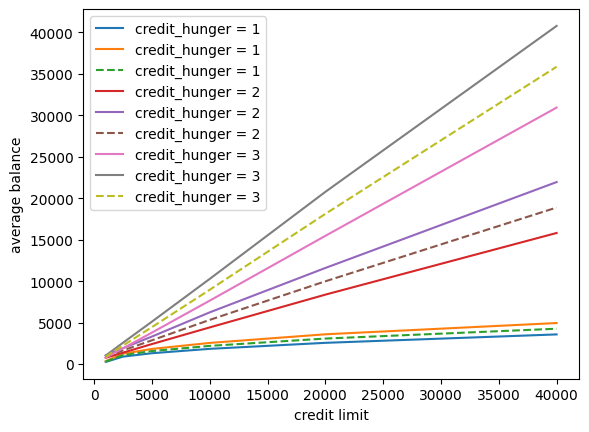

In [3]:
sim_df = SimulatedCreditLimitDataset()
sim_df.create_simulated_dataset()
sim_df.plot_true_relationship()
# sim_df.plot_limit_by_score()

In [4]:
df = sim_df.df
buckets, bins = pd.qcut(df['credit_score'],10,retbins=True)

# buckets.nunique()
lab = [f"{n}. [{ int(bins[n]) },{ int(bins[n+1]) })" for n in range(buckets.nunique())]

pd.cut(df['credit_score'], bins, labels = lab)

0       8. [584,630)
1       4. [475,501)
2       9. [630,700)
3       3. [447,475)
4                NaN
            ...     
9995    1. [374,416)
9996    8. [584,630)
9997    5. [501,527)
9998    4. [475,501)
9999    2. [416,447)
Name: credit_score, Length: 10000, dtype: category
Categories (10, object): ['0. [300,374)' < '1. [374,416)' < '2. [416,447)' < '3. [447,475)' ... '6. [527,553)' < '7. [553,584)' < '8. [584,630)' < '9. [630,700)']

# 2. S-Learner

Add treatment variable in the training dataset; estimate treatment effect by plugging in different values of treatment variable

In this section we will

1) Construct a S-Learner using LightGBM models to build intuition on what's happening under the hood
2) Look at how well it is capturing the "true" relationship
3) Cumulative gain chart (or its equivalent for a continuous treatment variable anyway)
4) What if credit hunger is not observable?
5) What if credit limit in the training dataset was fully deterministic? (i.e. no limit testing going on; default scenario assumes 5% limit testing on adjacent limits)

In [54]:
sim_df_det = SimulatedCreditLimitDataset()
sim_df_det.create_simulated_dataset(**{'limit_test_perc': 0.05})


sim_df_rnd = SimulatedCreditLimitDataset()
sim_df_rnd.create_simulated_dataset(**{'limit_test_perc':1})

C:\Users\maoru\AppData\Local\Temp\ipykernel_7604\2833390648.py:184: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _df.groupby(['credit_score_bucket'])
C:\Users\maoru\AppData\Local\Temp\ipykernel_7604\2833390648.py:200: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\maoru\AppData\Local\Temp\ipykernel_7604\2833390648.py:184: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _df.groupby(['credit_score_bucket'])
C:\Users\maoru\AppData\Local\Temp\ipykernel_7604\2833390648.py:200: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


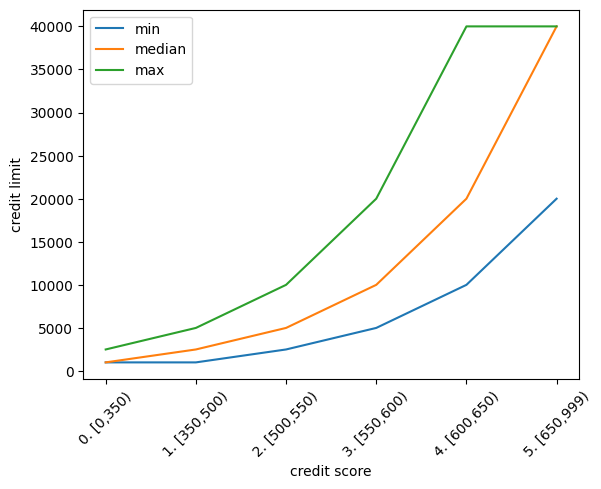

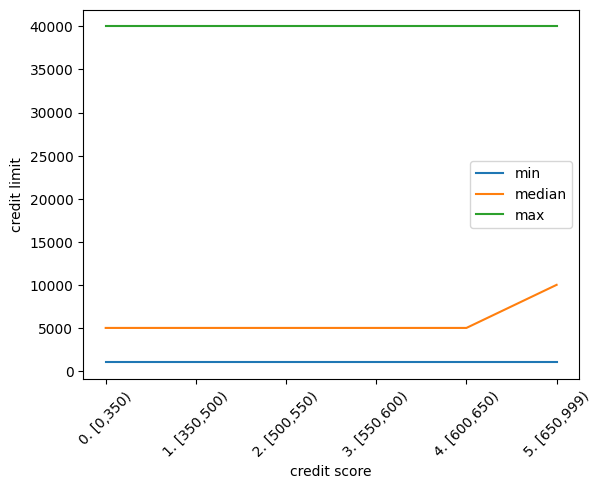

In [55]:
# Inspect data created
sim_df_det.plot_limit_by_score()
sim_df_rnd.plot_limit_by_score()

In [56]:
X = ['credit_hunger', 'credit_score']
# X = ['credit_score']
T = 'credit_limit'
y = 'balance'

df_train = sim_df_det.df
df_test = sim_df_rnd.df

s_learner = LGBMRegressor(max_depth=3, min_child_samples=30, verbosity=-1)
s_learner.fit(df_train[X+[T]], df_train['balance'])

df_train['pred_balance'] = s_learner.predict(df_train[X+[T]])
df_test['pred_balance'] = s_learner.predict(df_test[X+[T]])

In [57]:
def plot_true_vs_pred_relationship(
        df: pd.DataFrame 
):
    
    _dff = (
        df.groupby(['credit_hunger', 'credit_limit'])
        .aggregate({'balance':['mean','std'], 'pred_balance':'mean'})
        .reset_index()
    )

    _dff.columns = ["_".join(x) if len(x[1])>0 else x[0] for x in _dff.columns]
        
    fig, ax = plt.subplots()

    for h in [1,2,3]:
        ax.plot(
            'credit_limit', 'balance_mean'
            , data = _dff.loc[_dff['credit_hunger']==h]
            , label=f"credit_hunger = {h}"
            )
        
        ax.plot(
            'credit_limit', 'pred_balance_mean'
            , data = _dff.loc[_dff['credit_hunger']==h]
            , ls = '--'
            , label=f"credit_hunger = {h}"
            )


    ax.legend()
    ax.set_xlabel('credit limit')
    ax.set_ylabel("average balance")
    fig.show()

C:\Users\maoru\AppData\Local\Temp\ipykernel_7604\1565937206.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


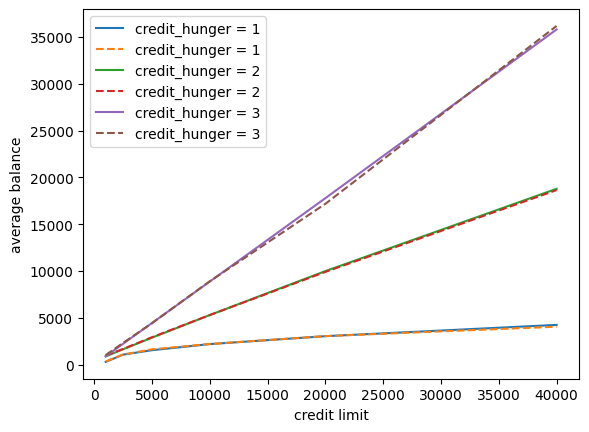

In [58]:
plot_true_vs_pred_relationship(df_test)

In [59]:
df_test 

,credit_hunger,credit_score,credit_limit,balance,credit_score_bucket,pred_balance
0,3,418,20000,15954,"1. [350,500)",17129.116603
1,1,436,40000,3990,"1. [350,500)",4041.300086
2,2,440,20000,9627,"1. [350,500)",9864.231563
3,1,559,2500,1002,"3. [550,600)",1060.918056
4,2,685,2500,1520,"5. [650,999)",1897.753897
...,...,...,...,...,...,...
9995,3,645,20000,19878,"4. [600,650)",17930.567196
9996,3,536,10000,8749,"2. [500,550)",8851.253530
9997,3,496,20000,17451,"1. [350,500)",17129.116603
9998,1,650,2500,1423,"4. [600,650)",1232.603024
